# Demobeispiel: Transfer Learning mit vortrainiertem CNN

In diesem Codebeispiel zum Thema Transfer Learning wird ein mit dem ImageNet trainiertes ResNet-50 Modell geladen und auf die Klassifikation von Hunden und Katzen umtrainert. 

<b>Vorsicht</b>: Das Training dieses umfangreichen Modells dauert auch über wenige Epochen je nach Hardware sehr lange (Stunden). 

## Bibliotheken einbinden

In [1]:
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

import pandas as pd
import matplotlib.pyplot as plt

## Daten laden, begutachten und vorverarbeiten
Hier wird ein Datensatz verwendet, der aus mehreren tausend Bildern von Hunden und Katzen besteht. Hierzu wird zunächst ein ZIP-File mit den Daten aus dem Internet heruntergeladen, entpackt und auf der Festplatte abgelegt.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')    

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

<b>Infos</b>: 
- Im heruntergeladenen ZIP-File sind die Daten bereits in die Ornder "train" und "validation" unterteilt. 
- Ein Beispielcode zum Laden eines nicht gezippten Datenbestandes findet sich hier: https://www.tensorflow.org/tutorials/load_data/images 

In [3]:
# Wo (im Dateisystem des Rechners) liegen die Daten nun?
PATH

'C:\\Users\\kubamatm.HS-KEMPTEN\\.keras\\datasets\\cats_and_dogs_filtered'

In [4]:
# Wie viele Bilder (Test und Val) wurden insgesamt heruntergeladen?
import pathlib

WIN_PATH_TRAIN = pathlib.Path(train_dir)   # Aus dem Pfad einen Windows-Pfad machen:
train_image_count = len(list(WIN_PATH_TRAIN.glob('*/*.jpg')))
print("Anzahl Bilder im Trainingsdatensatz:", train_image_count)

WIN_PATH_VAL = pathlib.Path(validation_dir)   # Aus dem Pfad einen Windows-Pfad machen:
val_image_count = len(list(WIN_PATH_VAL.glob('*/*.jpg')))
print("Anzahl Bilder im Validierungsdatensatz:", val_image_count)

Anzahl Bilder im Trainingsdatensatz: 2000
Anzahl Bilder im Validierungsdatensatz: 1000


Nun werden die auf der Festplatte abgelegten Daten eingelesen. Das Einlesen erfolgt in Batches der Größe 32. Außerdem werden die Bilder direkt auf die Abmessungen zugeschnitten, die vom später verwendeten Modell erwartet werden.

In [5]:
# Daten direkt in Batches der Größe 32 einlesen: 
BATCH_SIZE = 32

# Das später zu verwendende vortrainierte Modell erwartet Bilder der Größe 224 x 224 (x 3 Channels), 
# die geladenen Bilder (Hunde und Katzen) haben unterschiedliche Größen. 
IMG_SIZE = (224, 224)          

# Trainingsdaten einlesen:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

# Validierungsdaten einlesen: 
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


<b>Anmerkung</b>: Man beachte, dass die Daten in zufälliger Reihenfolge (shuffle=True) eingelesen werden, was grundsätzlich empfehlenswert ist. 

In [6]:
# Klassennamen ermitteln und ausgeben (entspricht den Namen der Ordner auf der Festplatte): 
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

In [7]:
# Paar Infos zum Shape der Daten (hier für Train-Daten, sieht für Val-Daten aber identisch aus):
for image_batch, labels_batch in train_dataset.take(1):  # take(1) heißt, es soll nur 1 Batch (also 32 Bilder) entnommen werden.    
    print(image_batch.shape)
    print(labels_batch.shape)    

(32, 224, 224, 3)
(32,)


<b>Infos</b>: 
- In einem Batch befinden sich 32 Bilder (mit je 224 x 224 Pixeln und 3 Farbkanälen). Zu jedem Bild existiert ein Label.
- train_dataset ist ein Batch-basierter TF-Dataset der (zumindest hier) pro Datenpunkt ein Tupel aus Bild 
 und Label liefert, auf das am einfachsten mittels for-Anweisung getrennt zugegriffen werden kann. 

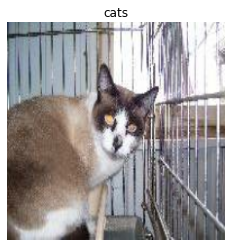

In [8]:
# Darstellen eines beispielhaften Bildes (inkusive Label):
for image_batch, labels_batch in train_dataset.take(1):      
    plt.imshow(image_batch[0].numpy()/255)   # train_dataset ist ein TF-Dataset. Für imshow daher erst in np-Array umwandeln (und auf Pixelwerte zwischen 0 und 1 normieren, statt wie aktuell in train_dataset zwischen 0 und 255)
    plt.title(class_names[labels_batch[0]]) 
    plt.axis("off")    
    
plt.show()

# Anm.: Die take()-Methode wählt das Bild aus dem Datensatz zufällig aus.

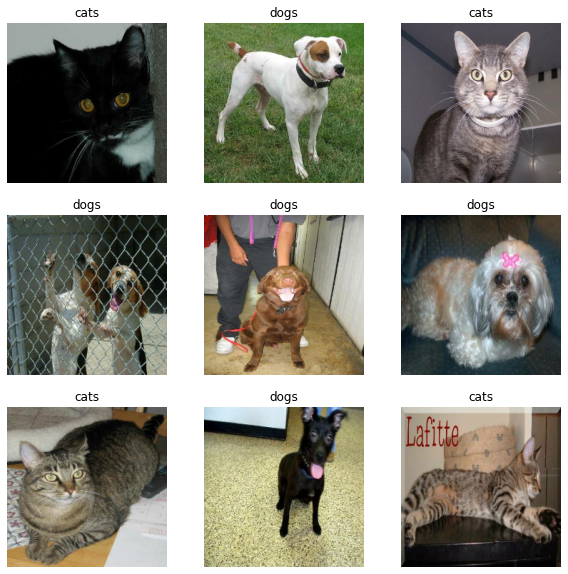

In [9]:
# Darstellen einiger Bilder aus dem Train-Datensatz (Anm.: Auch hier werden zufällige Batches aus dem Datensatz entnommen.)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):      # take(1) heißt hier: Nimm (zufällig) einen Batch (d.h. 32 Bilder)
    for i in range(9):                            # Daher: Aus diesen 32 Bildern die ersten 9 nehmen und darstellen. 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255)         # train_dataset ist ein TF-Dataset. Für imshow daher erst in np-Array umwandeln (und auf Pixelwerte zwischen 0 und 1 normieren, statt wie aktuell in full_data zwischen 0 und 255)
        plt.title(class_names[labels[i]])         # Korrektes Label über dem Bild darstellen   
        plt.axis("off")
        
plt.show()

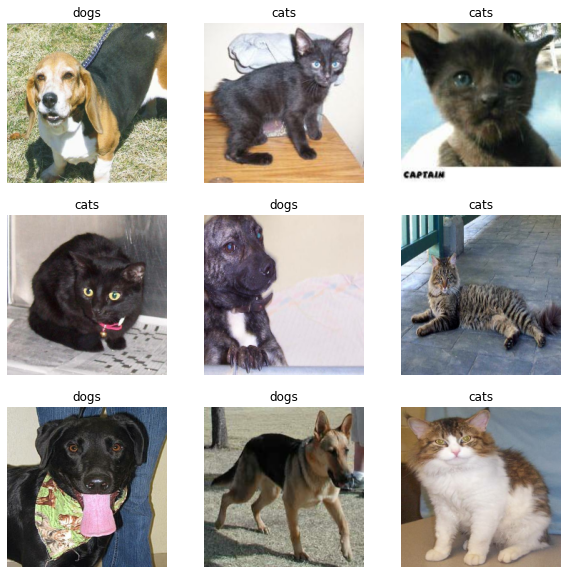

In [10]:
# Dasselbe nochmal für den Val-Datensatz (Anm.: Auch hier werden zufällige Batches aus dem Datensatz entnommen.):
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):      # take(1) heißt hier: Nimm einen Batch (d.h. 32 Bilder)
    for i in range(9):                                 # Daher: Aus diesen 32 Bildern die ersten 9 nehmen und darstellen. 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255)              # full_data ist ein TF-Dataset. Für imshow daher erst in np-Array umwandeln (und auf Pixelwerte zwischen 0 und 1 normieren, statt wie aktuell in full_data zwischen 0 und 255)
        plt.title(class_names[labels[i]])              # Korrektes Label über dem Bild darstellen   
        plt.axis("off")
        
plt.show()

Der geladene Datensatz beinhaltet noch keine Testdaten. Diese werden daher hier im Umfang von 20 % dem Validierungsdatensatz entnommen.

In [11]:
val_batches = len(validation_dataset)
print('Anzahl der Validation Batches (vor dem Splitten): %d' % val_batches)

test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
# Info: Die Division mittels // liefert direkt ein gerundetes Ganzzahl-Ergebnis.

print('Anzahl der Validation Batches (nach dem Splitten): %d' % len(validation_dataset))
print('Anzahl der Test Batches (nach dem Splitten): %d' % len(test_dataset))

Anzahl der Validation Batches (vor dem Splitten): 32
Anzahl der Validation Batches (nach dem Splitten): 26
Anzahl der Test Batches (nach dem Splitten): 6


Zur Klassifikation der Bildinhalte soll später ein vortrainiertes ResNet-50 Modell umtrainiert und verwendet werden. Dieses Modell kann mit den Bildern, so wie sie aktuell im Datensatz vorliegen, nicht umgehen. Durch Verwendung der speziellen preprocess_input()-Methode werden die Bilder für das Modell vorbereitet. Hier werden u. a. die Daten von RGB nach BGR umgerechnet und die Werte zentriert und skaliert. 

Siehe auch https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input?hl=de.

In [12]:
# Preprocessing-Layer des vorhandenen ResNet50-Modells verwenden: 
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Laden und umtrainieren eines ResNet-50 Modells
Als Ausgangspunkt für das zu trainierende CNN Modell soll ein vortrainiertes ResNet-50 Modell (nachfolgend auch als Basismodell bezeichnet) verwendet werden. Dieses wurde mit dem ImageNet Datensatz (= 1,4 Millionen Bilder mit 1000 Klassen) vortrainiert. 

In [13]:
# Zunächst: Shape der Bilder festlegen (224x224 Pixel, 3 Kanäle):
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SIZE)           # (224, 224)
print(IMG_SHAPE)          # (224, 224, 3)

(224, 224)
(224, 224, 3)


<b>Basismodell laden</b>

Zunächst ist zu bestimmen, welche Layer des ResNet-50 Modells als Feature Extractor für das finale CNN verwendet werden sollen. Üblicherweise wird hierfür der Feature Extractor des Basismodells weiterverwendet, während der Classfier (also die Upper Layer ab dem Flatten Layer - auch als *Bottleneck Layer* bezeichnet) verworfen wird. Dies kann beim Instanziieren des vortrainierten Modells durch den Parameter "include_top=False" bewerkstelligt werden, was dazu führt, dass die Classification Layer des Basismodells verworfen werden.

In [14]:
# Basismodell (= Feature Extractor von ResNet-50) instanziieren:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet') 

In [15]:
# Infos zu den Layern im Basismodell ausgeben: 
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
# Just for Fun: Einen Batch (d.h. 32 Bilder) aus dem Train-Datensatz nehmen und das Basismodell darauf anwenden
# (um die Shapes der Ausgangsdaten zu sehen):
for image_batch, label_batch in train_dataset.take(1):  # Einen Batch (d.h. 32 Bilder) aus dem Train-Datensatz nehmen
    feature_batch = base_model(image_batch)             # Das Basismodell auf ein Batch anwenden

print("Image Batch Shape:", image_batch.shape)          # Shape des Input-Batches ansehen
print("Label Batch Shape:", label_batch.shape)          # Shape der Labels in diesem Batch ansehen
print("Feature Batch Shape:", feature_batch.shape)      # Shape des Output-Batches (=Ausgangsdaten des base_model) ansehen.

Image Batch Shape: (32, 224, 224, 3)
Label Batch Shape: (32,)
Feature Batch Shape: (32, 7, 7, 2048)


<b>Fazit</b>: Dieser Feature Extractor wandelt jedes 224x224x3 Bild in ein 7x7x2048 Array.

<b>Basismodell einfrieren</b>

Im nächsten Schritt wird das Basismodell eingefroren und als (nicht trainierbarer) Feature Extractor verwendet. Das eingefrorene Modell wird anschließend um trainierbare Classification Layer erweitert. 

Hierfür ist es wichtig, dass das Basismodell vor Compiling und Training eingefroren wird. Einzelne Layer eines Modells lassen sich mittels "layer.trainable = False" einfrieren - siehe weiter unten. Da hier das gesamte Basismodell (und nicht nur einzelne Layer) eingefroren werden soll, kann einfach der trainable-Parameter des Modells auf False gesetzt werden. 

In [17]:
# Gesamtes Basismodell einfrieren:
base_model.trainable = False

In [18]:
# Nochmal Infos zu den Layern im Basismodell ausgeben: 
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Wie man sieht sind jetzt (im Gegensatz zu oben, bevor "base_model.trainable = False" gesetzt wurde) alle Parameter im Modell "non-trainable". 

<b>Classification Layer erstellen</b>

Das Modell wird nun um einen GlobalAveragePooling2D Layer ergänzt. Dieser berechnet pro Feature Map des Eingangssignals (jede Feature Map, die aus dem Feature Extractor kommt, hat eine Größe von 7x7, insgesamt sind es 2048 Feature Maps) den Durchschnittswert, so dass das Ausgangssignal dieses Pooling Layers einen Vektor mit 2048 Elementen darstellt. Mit anderen Worten: Ein Bild (224x224x3) wird durch den Feature Extractor in ein 7x7x2048 Array umgerechnet, der auf den Feature Extractor folgende Pooling Layer macht daraus einen Vektor der Größe 2048. 

In [19]:
# GlobalAveragePooling2D-Layer: 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [20]:
# Just for Fun: Diesen Layer auf ein Batch anwenden, das aus dem base_model rauskommt 
# (um den Shape der Daten zu sehen): 
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Anschließend wird das Modell um einen Dense Layer mit einem Neuron mit Sigmoid-Aktivierung ergänzt. Grund: Es handelt sich um ein binäres Klassifikationsproblem (Hunde vs. Katzen).

In [21]:
# Dense Layer:
prediction_layer = tf.keras.layers.Dense(1, activation="sigmoid")

In [22]:
# Just for Fun: Diesen Layer auf ein Batch anwenden (um den Shape der Daten zu sehen): 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


<b>Modell erstellen</b>

Nun wird das Modell erstellt durch Zusammenfügen des Basismodells und der beiden zuletzt erzeugten Classification Layer, hier mittels Keras Functional API. Zusätzlich soll noch ein Dropout-Layer zur Generalisierung eingefügt werden.

In [23]:
inputs = tf.keras.layers.Input(shape=IMG_SHAPE)   # Shape der Eingangssignale angeben
x = preprocess_input(inputs)                      # Preprocessing Layer
x = base_model(x, training=False)                 # Basismodell bzw. Feature Extractor (bereits oben eingefroren + training=False für Batch-Norm Layer - siehe Anmerkung unten)
x = global_average_layer(x)                       # Pooling Layer des Classifiers
x = tf.keras.layers.Dropout(0.2)(x)               # Dropout Layer zur Generalisierung
outputs = prediction_layer(x)                     # Prediction Layer (= Dense Layer zur Ermittlung des Klassifikationsergebnis)
model = tf.keras.Model(inputs, outputs)           # Modell erstellen

<b>Anmerkung</b>: 
Das Argument "training=False" des Basismodells hat zur Folge, dass die bereits (aus dem Vorab-Training) vorliegenden Werte (Mittelwert und Standardabweichung) der Batch-Norm Layers des Basismodells weiterverwendet werden, und nicht die Mittelwerte und Standardaweichungen der Batches des neuen Datensatzes - und zwar auch dann, wenn das Basismodell für das Fine Tuning wieder trainable gemacht wird - siehe weiter unten. 

Dies sollte stets beachtet werden, wenn ein Basismodell verwendet wird, das Batch-Normalization Layer beinhaltet. Andernfalls "verlernt" das Basismodell / der Feature Extractor das, was zuvor im Vorab-Training bereits erlernt wurde.

<b>Modell kompilieren</b>

Da es sich um ein binäres Klassifikationsproblem handelt, wird hier als Loss "binary_crossentropy" gewählt. Die Lernrate kann i. d. R. zunächst verhältnismäßig groß gewählt werden. 

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

<b>Anmerkung</b>: Die rund 24 Millionen Parameter des ResNet-50 Modells sind eingefroren ("non-trainable"). Die 2049 Parameter (2048 Gewichte und ein Bias Term) des selbst erstellten Dense Layers hingegen sind "trainable". 

<b>Modell trainieren</b>

Das erstellte Modell wird nun zunächst (mit verhältnismäßig großer Lernrate) über einige wenige Epochen trainiert.

In [26]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)

Epoch 1/5
63/63 [==============================] - 314s 5s/step - loss: 0.8437 - accuracy: 0.4510 - val_loss: 0.5904 - val_accuracy: 0.6931
Epoch 2/5
63/63 [==============================] - 1755s 28s/step - loss: 0.4955 - accuracy: 0.7780 - val_loss: 0.3594 - val_accuracy: 0.8960
Epoch 3/5
63/63 [==============================] - 269s 4s/step - loss: 0.3379 - accuracy: 0.8920 - val_loss: 0.2559 - val_accuracy: 0.9493
Epoch 4/5
63/63 [==============================] - 281s 4s/step - loss: 0.2464 - accuracy: 0.9380 - val_loss: 0.1941 - val_accuracy: 0.9641
Epoch 5/5
63/63 [==============================] - 286s 5s/step - loss: 0.1994 - accuracy: 0.9555 - val_loss: 0.1543 - val_accuracy: 0.9790


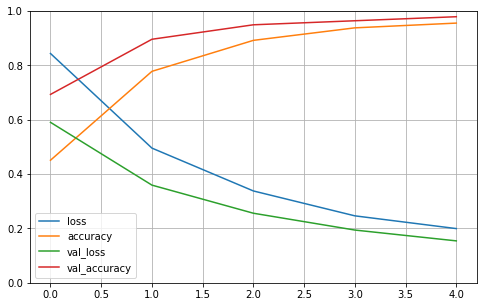

In [27]:
# Lernkurve darstellen:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

<b>Anmerkungen</b>: 
- Bereits nach wenigen Epochen zeigt das Modell recht gute Resultate. 
- Wie sich zeigt, sind die Metriken (Loss und Accarcy) auf den Validierungsdaten besser als auf den Trainingsdaten. Dies liegt insbesondere am Dropout Layer, der die Accuracy im Rahmen des Trainings häufig negativ  beeinflusst (im Sinne der Generalisierung des Modells), für die Prädiktion (also auch für die Anwendung des Modells auf die Validierungsdaten) aber inaktiv ist. 

<b>Fine Tuning</b>

In einem zweiten Trainingsschritt soll nun das Fine Tuning des Modells vorgenommen werden. Hierzu werden einige Upper Layer des Feature Extractors trainierbar gemacht (abgesehen von den Batch-Norm Layern, wie bereits weiter oben erläutert) und das Gesamtmodell mit den neuen Daten über einige Epochen trainiert. Dieser Schritt bringt häufig nochmals ein paar Prozentpunkte Verbesserung der Accuracy. 

Zunächst wird das gesamte Basismodell trainierbar gemacht: 

In [28]:
base_model.trainable = True

In [29]:
# Ermitteln, wie viele Layer das Basismodell aufweist: 
print("Anzahl der Layer im Basismodell:", len(base_model.layers))

Anzahl der Layer im Basismodell: 175


Als nächstes sind jene Layer im Basismodell, die im Rahmen des Fine Tuning nicht trainiert werden sollen, wieder einzufrieren. 

In [30]:
# Das Fine Tuning soll ab Layer 140 stattfinden, die Lower Layer sollen eingefroren werden.
fine_tune_at = 140

# Die unteren 139 Layer einfrieren: 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Anschließend muss das Modell erneut kompiliert werden. Für das Fine Tuning ist es ratsam, die Lernrate deutlich kleiner zu wählen, da das Modell (das nun deutlich mehr trainierbare Parameter aufweist) sonst sehr schnell overfittet. 

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

Man erkennt: Nun sind deutlich mehr Parameter trainable als zuvor, als vom Basismodell nur der Top-Layer trainiert wurde. 

Nun wird das Training des Modells (im Sinne des Fine Tuning) fortgesetzt, d. h. es wird das Training dort aufgenommen, wo es zuvor geendet hat. Die Gewichte, die das Modell zu Beginn des Fine Tuning aufweist sind also die Gewicht, die das Modell bislang gelernt hat. Dies erfolgt einfach durch erneuten Aufruf der fit()-Methode. 

In [33]:
history_fine = model.fit(train_dataset,
                         epochs=10,                         
                         validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 423s 7s/step - loss: 0.0645 - accuracy: 0.9805 - val_loss: 0.0200 - val_accuracy: 0.9926
Epoch 2/10
63/63 [==============================] - 420s 7s/step - loss: 0.0080 - accuracy: 0.9990 - val_loss: 0.0192 - val_accuracy: 0.9913
Epoch 3/10
63/63 [==============================] - 419s 7s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 0.9901
Epoch 4/10
63/63 [==============================] - 420s 7s/step - loss: 9.8685e-04 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9926
Epoch 5/10
63/63 [==============================] - 422s 7s/step - loss: 4.3949e-04 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 0.9926
Epoch 6/10
63/63 [==============================] - 425s 7s/step - loss: 2.5964e-04 - accuracy: 1.0000 - val_loss: 0.0184 - val_accuracy: 0.9938
Epoch 7/10
63/63 [==============================] - 431s 7s/step - loss: 2.2445e-04 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.99

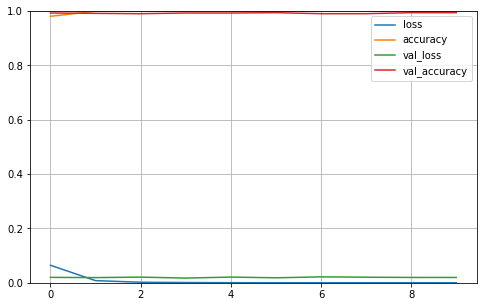

In [34]:
# Lernkurve des Fine Tuning darstellen: 
pd.DataFrame(history_fine.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

Wie man sieht zeigt das Modell für den vorliegenden Datensatz sehr gute Ergebnisse. 

<b>Modell evaluieren und anwenden</b>

Accuracy (und Loss) auf den Testdaten ermitteln:

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 31s 5s/step - loss: 0.0063 - accuracy: 1.0000
Test accuracy : 1.0


Modell auf ein paar exemplarische Testdaten anwenden: 

In [36]:
for image_batch, label_batch in test_dataset.take(1):   # Einen Batch (d.h. 32 Bilder) aus dem Test-Datensatz nehmen.
    prediction_probas = model.predict(image_batch)      # Predicitions (=Klassenwahrscheinlichkeiten) für alle Bilder in diesem Batch erstellen

prediction_probas = prediction_probas.flatten()         # flatten(), um aus dem Spaltenvektor einen Zeilenvektor zu machen. 
predictions = tf.where(prediction_probas < 0.5, 0, 1)   # Werte auf 0 bzw 1 abbilden    

In [37]:
prediction_probas

array([3.7486639e-06, 3.5606917e-11, 2.0243093e-08, 3.5008764e-08,
       1.7705957e-05, 9.9999559e-01, 1.0000000e+00, 1.9064954e-09,
       9.9999893e-01, 9.9999839e-01, 1.0000000e+00, 5.7694649e-10,
       1.0406799e-09, 1.0000000e+00, 9.9999714e-01, 4.9526169e-12,
       1.0000000e+00, 1.0000000e+00, 9.9999976e-01, 1.0000000e+00,
       9.9978650e-01, 9.9998850e-01, 1.7555513e-10, 4.3955220e-07,
       1.0000000e+00, 9.9999619e-01, 9.9999970e-01, 1.3412228e-01,
       3.4324427e-12, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
      dtype=float32)

In [38]:
# Predictions und korrekte Labels vergleichen:
print('Vorhersagen:    ', predictions.numpy())
print('Korrekte Labels:', label_batch.numpy())

Vorhersagen:     [0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1]
Korrekte Labels: [0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1]


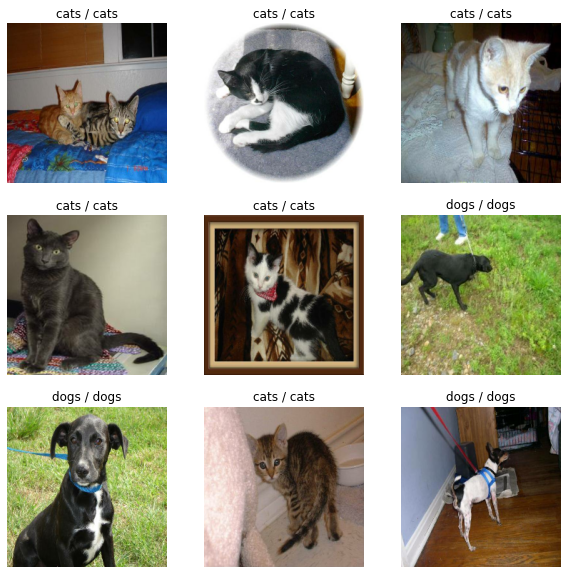

In [39]:
# Das Ganze für ein paar exemplarische Bilder darstellen (inklusive Labels):
plt.figure(figsize=(10, 10))
for i in range(9):                       # Aus dem Batch (32 Bilder) die ersten 9 nehmen und darstellen
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy()/255)   # full_data ist ein TF-Dataset. Für imshow daher erst in np-Array umwandeln (und auf Pixelwerte zwischen 0 und 1 normieren, statt wie aktuell in full_data zwischen 0 und 255)
    plt.title("%s / %s" % (class_names[predictions[i]], class_names[label_batch[i]]))     # Vorhergesagtes und korrektes Label über dem Bild darstellen   
    plt.axis("off")

plt.show()